Tutorial 6: Alternative Searches
================================

Up to now, we've always used the non-linear search Dynesty and not considered the input parameters that control its
sampling. In this tutorial, we'll consider how we can change these setting to balance finding the global maxima
solution with fast run time, as well as other types of non-linear searches we can use to perform lens modeling.

In [1]:
%matplotlib inline

from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

conf.instance = conf.Config(
    config_path=f"{workspace_path}/howtolens/config",
    output_path=f"{workspace_path}/howtolens/output",
)

Workspace Path:  /home/carlos/autolens_workspace


We’ll use new strong lensing data, where:

    The lens galaxy’s LightProfile is an EllipticalSersic.
    The lens galaxy’s MassProfile is an EllipticalIsothermal.
    The source galaxy’s LightProfile is an EllipticalSersic.


In [2]:
from howtolens.simulators.chapter_2 import (
    lens_sersic_sie__source_sersic,
)

dataset_type = "chapter_2"
dataset_name = "lens_sersic_sie__source_sersic"
dataset_path = f"{workspace_path}/howtolens/dataset/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise_map.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=0.1,
)

We’ll create and use a smaller 2.0” Mask again.

In [3]:
mask = al.Mask.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, radius=2.6
)

When plotted, the lens light’s is clearly visible in the centre of the image.

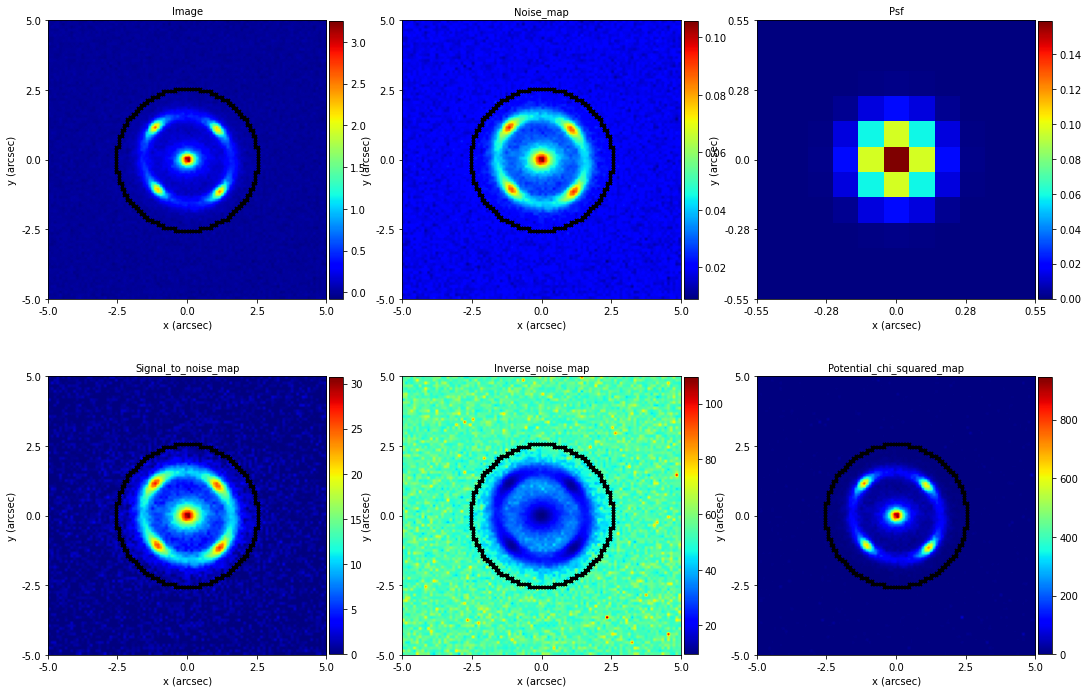

In [4]:
aplt.Imaging.subplot_imaging(imaging=imaging, mask=mask)

Like in the previous tutorial, we use a_PhaseSettingsImaging_ object to specify our model-fitting procedure uses a regular Grid.

In [5]:
settings = al.PhaseSettingsImaging(grid_class=al.Grid, sub_size=2)

__Nested Sampling__

Lets first perform the model-fit using Dynesty, but first discuss in a bit more detail how Dynesty works.

Dynesty is a 'nested sampling' algorithm. As we described in tutorial 1, it throws down a set of 'live points' in 
parameter space, where each live point corresponds to a lens model with a given set of parameters. These points are
intially distributed according to our priors, hence why tuning our priors allows us to sample parameter space faster.

The following settings control how fast a nested sampling algorithm samples non-linear parameter space:

n_live_points:

    The number of live points which sample parameter space. More points provide a more thorough sampling of parameter 
    space, increasing the probability that we locate the global maxima solution at the expense if taking longer to 
    convergence on this solution. Ideally, we would use as few live pooints as possible to locate the global maxima
    as quickly as possible.

evidence_tolerance : float

    Dynesty stops sampling when it estimates that it has converged on the global maxima solution in parameter space and
    that continuing sampling will not increase the log likelihoods of the current live points more than this evidence
    tolerance value. For example, an evidence tolerance of 1.0 roughly require that all live points have log likelihood
    values within 1.0 of one another. Thus, the higher the evidence_tolerance the sooner Dynesty will stop running. 
    
    A high tolerance will make the errors estimated on every parameter unreliable, and the tolerance must be kept below
    0.8 if you want reliable error estimates. However, when linking phases, we typically *do not care* about the errors 
    in the first phase, therefore setting a high evidence tolerance can be an effective means to make Dynesty converge
    faster. 

Lets perform two fits, where:

 - One has many live points, a low sampling efficiency and evidence tolerance, causing the non-linear search to
      take a long time to run (in fact, on my laptop, this run takes > 500000 iterations which translates to > 6 
      hours. So, I've commented the run function out to not waste your time, but feel free to uncomment it and run
      the phase to see this for yourself!).
      
 - One has few live points, a high sampling efficiency and evidence tolerance, causing the non-linear search to
      converge and end quicker.

In [6]:
phase_slow = al.PhaseImaging(
    phase_name="phase_t6_slow",
    settings=settings,
    galaxies=dict(
        lens=al.GalaxyModel(
            redshift=0.5, light=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
        ),
        source=al.GalaxyModel(redshift=1.0, light=al.lp.EllipticalSersic),
    ),
    search=af.DynestyStatic(n_live_points=150, evidence_tolerance=0.8),
)

In [7]:
print(
    "Dynesty has begun running - checkout the workspace/output"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

# #result_slow = phase_slow.run(dataset=imaging, mask=mask)

Dynesty has begun running - checkout the workspace/output folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!


Lets check that we get a good model and fit to the data.

In [8]:
# aplt.FitImaging.subplot_fit_imaging(fit=result_slow.max_log_likelihood_fit)

We can use the result to tell us how many iterations Dynesty took to convergence on the solution.

In [9]:
print("Total Dynesty Iterations (If you skip running the phase, this is ~ 500000):")
# print(result_slow.samples.total_samples)

Total Dynesty Iterations (If you skip running the phase, this is ~ 500000):


Now lets run the phase with fast setting, so we can compare the total number of iterations required.

In [14]:
phase_fast = al.PhaseImaging(
    phase_name="phase_t6_fast",
    settings=settings,
    galaxies=dict(
        lens=al.GalaxyModel(
            redshift=0.5, light=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
        ),
        source=al.GalaxyModel(redshift=1.0, light=al.lp.EllipticalSersic),
    ),
    search=af.DynestyStatic(n_live_points=30),
)

In [15]:
print(
    "Dynesty has begun running - checkout the workspace/output"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

# result_fast = phase_fast.run(dataset=imaging, mask=mask)

print("Dynesty has finished run - you may now continue the notebook.")

Dynesty has begun running - checkout the workspace/output folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!
Dynesty has finished run - you may now continue the notebook.


Lets check that this search, despite its faster sampling settings, still gives us the global maxima solution.

In [16]:
# aplt.FitImaging.subplot_fit_imaging(fit=result_fast.max_log_likelihood_fit)

And now lets confirm it uses significantly fewer iterations.

In [17]:
print("Total Dynesty Iterations:")
print("Slow settings: ~500000")
# print(result_slow.samples.total_samples)
# print("Fast settings: ", result_fast.samples.total_samples)

Total Dynesty Iterations:
Slow settings: ~500000


__Optimizers__

Nested sampling algorithms like Dynesty provides the errors on all of the model parameters, by fully mapping out all 
of the high likelihood regions of parameter space. This provides knowledge on the complete *range* of models that do 
and do not provide high likelihood fits to the data, but takes many extra iterations to perform. If we require precise 
error estimates (perhaps this is our final lens model fit before we publish the results in a paper), these extra
iterations are acceptable. 

However, we often don't care about the errors. For example, in the previous tutorial when linking phases, the only 
result we used from the fit performed in the first phase was the maximum log likelihood model, omitting the errors
entirely! Its seems wasteful to use a nested sampling algorithm like Dynesty to map out the entirity of parameter
space when we don't use this information! 

There are a class of non-linear searches called 'optimizers', which seek to optimize just one thing, the log 
likelihood. They want to find the model that maximizes the log likelihood, with no regard for the errors, thus not 
wasting time mapping out in intricate detail every facet of parameter space. Lets see how much faster we can find a 
good fit to the lens data using an optimizer.

We'll use the 'Particle Swarm Optimizer' PySwarms. Conceptually this works quite similar to Dynesty, it has a set of 
points in parameter space (called 'particles') and it uses their likelihoods to determine where it thinks the higher
likelihood regions of parameter space are. 

Unlike Dynesty, this algorithm requires us to specify how many iterations it should perform to find the global 
maxima solutions. Here, an iteration is the number of samples performed by every particle, so the total number of
iterations is n_particles * iters. Lets try a total of ? iterations, a factor ? less than our Dynesty runs above. 

Dynesty has begun running - checkout the workspace/output folder for live output of the results, images and lens model. This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No PySwarms samples found, beginning new non-linear search. 
INFO:root:Running PySwarmsGlobal Optimizer...
2020-07-14 12:57:35,207 - pyswarms.single.local_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
pyswarms.single.local_best: 100%|██████████|500/500, best_cost=-1.26e+6
2020-07-14 13:07:20,013 - pyswarms.single.local_best - INFO - Optimization finished | best cost: -1255667.0630100744, best pos: [-3.98504911e-01  2.72092158e-01 -9.77040752e-01 -6.35553496e-01
  2.24545478e-02  2.17049479e+01  4.62726249e+00  7.09023117e-02
 -2.83060737e-01 -8.11475750e-01  5.57970474e-01  1.89426869e+00
  2.29465876e-01  8.79196679e-02  5.66472692e-01  7.73071557e-01
  1.35311023e-06  2.88663783e+01  3.99726733e+00]
2020-07-14 13:07:20,022 - root - INFO - 500 Iterations: Performing update (Visualization, outputting samples, etc.).
2020-07-14 13

PySwarms has finished run - you may now continue the notebook.


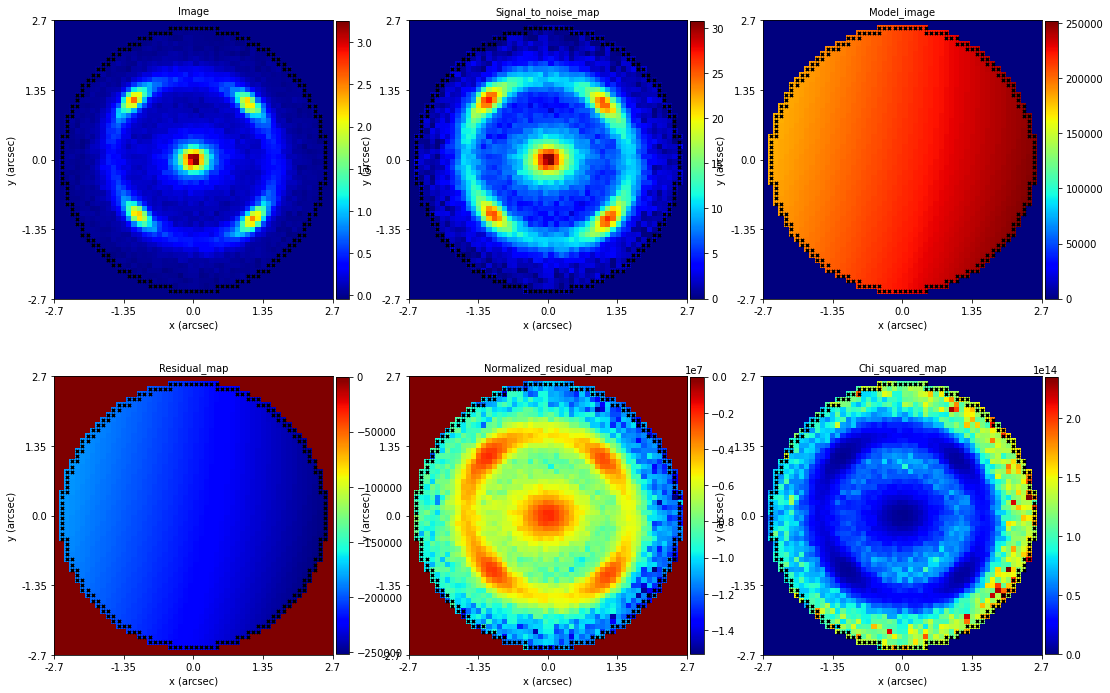

In [18]:
phase_pso = al.PhaseImaging(
    phase_name="phase_t7_pso",
    settings=settings,
    galaxies=dict(
        lens=al.GalaxyModel(
            redshift=0.5, light=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
        ),
        source=al.GalaxyModel(redshift=1.0, light=al.lp.EllipticalSersic),
    ),
    search=af.PySwarmsLocal(n_particles=50, iters=1000),
)

print(
    "Dynesty has begun running - checkout the workspace/output"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

result_pso = phase_pso.run(dataset=imaging, mask=mask)

print("PySwarms has finished run - you may now continue the notebook.")

aplt.FitImaging.subplot_fit_imaging(fit=result_pso.max_log_likelihood_fit)

It worked, and was much faster than Dynesty!

So, when should we use Dynesty and when should we use PySwarms? Its simple:

 - If we don't care about errors and want to get the global maxima solution as quickly as possible, we should use
      PySwarms.
      
 - If we want a model with robust and precise errors, we should use Dynesty.
    
There is one exception however, for complex models whose priors have not be well tuned or initialized by a previous 
phase, PySwarms has a tendancy to locate a local maxima. Dynesty's slower but more complete sampling of parameter space 
will often find the global maxima when PySwarms doesn't. So, if you're not happy with the results PySwarms is giving, 
it may be shrewd to bite-the-button on run-time and use Dynesty to get your initial lens model fit.

In the next chapter, when we introduce pipelines, you'll note that are our general strategy to lens modeling is to
initialize the model-fit with Dynesty, perform intermediate phases that refine the model with PySwarms and then
end with Dynesty for robust errors. Here, we choose our non-linear searches based on what result we want!

__MCMC__

For users familiar with Markov Chain Monte Carlo (MCMC) non-linear samplers, PyAutoFit supports the non-linear
search *Emcee* (af.Emcee). We have found this to be less effective at lens modeling than Dynesty and PySwarms,
but it is sill pretty successful. I've included an example run of Emcee below.


In [ ]:
phase_mcmc = al.PhaseImaging(
    phase_name="phase_t7_mcmc",
    settings=settings,
    galaxies=dict(
        lens=al.GalaxyModel(
            redshift=0.5, light=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
        ),
        source=al.GalaxyModel(redshift=1.0, light=al.lp.EllipticalSersic),
    ),
    search=af.Emcee(nwalkers=50, nsteps=1000),
)

print(
    "Emcee has begun running - checkout the workspace/output"
    " folder for live output of the results, images and lens model."
    " This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

# result_mcmc = phase_mcmc.run(dataset=imaging, mask=mask)

print("Emcee has finished run - you may now continue the notebook.")

# aplt.FitImaging.subplot_fit_imaging(fit=result_mcmc.max_log_likelihood_fit)
